# **Import Data from Google Drive**
Datapath: ./content/drive/My Drive/Colab Notebooks/melodies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Input Midi Data Processing** 
*by Sunghoon Kim*

In [ ]:
import music21
import os

In [ ]:
file_list = []

data_path = '/content/drive/My Drive/Colab Notebooks/melodies'

for file_name in os.listdir(os.path.expanduser(data_path)):
    if file_name.endswith('.mid'):
        file_list.append(data_path + '/' + file_name)

#for file in file_list:
#  print(file)

print("총 곡의 수는 " + str(len(file_list)) + "곡 입니다.")

총 곡의 수는 112곡 입니다.


In [ ]:
def create_mel_data_each_file(midi_obj):
    mel_data = dict()
    
    for note in midi_obj.flat.getElementsByClass(music21.note.Note):
        #offset
        if note.offset not in mel_data:
            mel_data[note.offset] = dict()
        mel_data[note.offset]['offset'] = note.offset
        
        #pitch
        prev_p = 0
        for p in note.pitches:
            if prev_p < p.midi:
                mel_data[note.offset]['note'] = p.midi
            prev_p = p.midi  
            
        #duration
        mel_data[note.offset]['duration'] = note.duration.quarterLength
        
    return mel_data

In [ ]:
mel_arr_list = []

for file_name in file_list:
    print(file_name)
    midi_obj = music21.converter.parse(file_name)
    mel_data = create_mel_data_each_file(midi_obj)

    mel_arr = []
    for key, value in sorted(mel_data.items()):
        mel_arr.append(mel_data[key])
    
    mel_arr_list.append(mel_arr)
    
first_pitch_list = []
for mel_arr in mel_arr_list:
    first_pitch_list.append([mel_arr[0]['note'], mel_arr[0]['duration']])

print(first_pitch_list)

/content/drive/My Drive/Colab Notebooks/melodies/nocturne_2_48.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_1_32.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_1_27.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_1_37.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_2_15.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_2_27.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_1_55.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_1_72.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_1_9.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_1_15.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_3_9.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_3_15.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_2_37.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_1_48.mid
/content/drive/My Drive/Colab Notebooks/melodies/nocturne_2_9.mi

In [ ]:
def create_curve_seq(mel_arr):
    curve_seq = []
    for idx in range(1, len(mel_arr)):
        curr_p_diff = mel_arr[idx]['note'] - mel_arr[idx-1]['note']
        curr_t_diff = mel_arr[idx]['offset'] - mel_arr[idx-1]['offset']
        duration = mel_arr[idx]['duration']
        
        curve_seq.append((curr_p_diff, curr_t_diff, duration))
    return curve_seq

In [ ]:
curve_seq_list = []
for mel_arr in mel_arr_list:
    curve_seq_list.append(create_curve_seq(mel_arr))

print("total number of song is: ", len(curve_seq_list))

total number of song is:  112


In [ ]:
for seq in curve_seq_list:
  print("the length of song is: ", len(seq))

the length of song is:  1108
the length of song is:  729
the length of song is:  983
the length of song is:  469
the length of song is:  857
the length of song is:  862
the length of song is:  934
the length of song is:  691
the length of song is:  1076
the length of song is:  786
the length of song is:  1381
the length of song is:  364
the length of song is:  750
the length of song is:  440
the length of song is:  317
the length of song is:  810
the length of song is:  813
the length of song is:  1116
the length of song is:  888
the length of song is:  577
the length of song is:  483
the length of song is:  1008
the length of song is:  388
the length of song is:  586
the length of song is:  374
the length of song is:  460
the length of song is:  339
the length of song is:  1032
the length of song is:  401
the length of song is:  674
the length of song is:  370
the length of song is:  764
the length of song is:  2667
the length of song is:  1860
the length of song is:  1363
the length 

In [ ]:
#Importing modules
import tensorflow
import keras
import numpy as np
import statistics 
import time
from numpy import newaxis
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, TimeDistributed, LeakyReLU
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.optimizers import Adam

# **Data Processing for LSTM**
*by Seungil Baek*

In [ ]:
#curve_seq_list to list

#int_input is 3-fold list
#int_input length is number of piece
#int_input[i] length is number of note
#int_input[i][j] length is 3, which is pitch, time1, time2 
int_input = []

#this has same size with int_input, and will be used in storing data in range(0,1)
rnn_input = []

#this contains spectrum of information integer, without repetition
note_info = []
time1_info = []
time2_info = []

#this is a sequence of note in 1-dimension form
note_seq = []
time1_seq = []
time2_seq = []

#generating int_input, info and seq
for i in range(0,len(curve_seq_list)):
    temp = [] #for int_input
    temp2 = [] #for rnn_input
    nonono = [] #to store the note data
    
    #first input process
    note0 = int((first_pitch_list[i][0]))
    time10 = 0
    time20 = int(round(12*first_pitch_list[i][1]))
    #note0 = int((curve_seq_list[i][0][0]+first_pitch_list[i][0]))
    #time10 = int(round(12*curve_seq_list[i][0][1]))
    #time20 = int(round(12*curve_seq_list[i][0][2]))

    if note0 not in note_info:
      note_info.append(note0)
    if time10 not in time1_info:
      time1_info.append(time10)
    if time20 not in time2_info:
      time2_info.append(max(1,time20))
    note_seq.append(note0)
    time1_seq.append(time10)
    time2_seq.append(max(1,time20))

    temp.append([note0, time10, time20])
    temp2.append([note0, time10, time20])
    nonono.append(note0)

    #middle input process
    for j in range(0,len(curve_seq_list[i])):
      nextnote = int((nonono[j] + curve_seq_list[i][j][0]))
      nexttime1 = int(round(12*curve_seq_list[i][j][1]))
      nexttime2 = max(1,int(round(12*curve_seq_list[i][j][2])))
      if nextnote not in note_info:
        note_info.append(nextnote)
      if nexttime1 not in time1_info:
        time1_info.append(nexttime1)
      if nexttime2 not in time2_info:
        time2_info.append(max(1,nexttime2))
      note_seq.append(nextnote)
      time1_seq.append(nexttime1)
      time2_seq.append(max(1,nexttime2))
      temp.append([nextnote,nexttime1,nexttime2])
      temp2.append([nextnote,nexttime1,nexttime2])
      nonono.append(nextnote)

    #last input is added to denote that the song is over
    lastnote = 0
    lasttime1 = 0
    lasttime2 = 0
    if lastnote not in note_info:
      note_info.append(lastnote)
    if lasttime1 not in time1_info:
      time1_info.append(lasttime1)
    if lasttime2 not in time2_info:
      time2_info.append(lasttime2)
    note_seq.append(lastnote)
    time1_seq.append(lasttime1)
    time2_seq.append(lasttime2)
    temp.append([lastnote,lasttime1,lasttime2])
    temp2.append([lastnote,lasttime1,lasttime2])
    int_input.append(temp)
    rnn_input.append(temp2)

In [ ]:
#note class classification
digit1 = []
digit10 = []
digit1_info = []
digit10_info = []

for note in note_seq:
  digit1.append(note%10)
  if note%10 not in digit1_info:
    digit1_info.append(note%10)
  digit10.append(note//10)
  if note//10 not in digit10_info:
    digit10_info.append(note//10)

#print(digit1)
#print(digit10_info)

In [ ]:
#info file은 중복되지 않은 데이터의 개수를 알고 있다.
#seq file will be used in one hot encoding process
note_info.sort()
digit1_info.sort()
digit10_info.sort()
time1_info.sort()
time2_info.sort()

note_class_num = len(note_info)
digit1_class_num = len(digit1_info)
digit10_class_num = len(digit10_info)
time1_class_num = len(time1_info)
time2_class_num = len(time2_info)

max_val_note = max(note_info)
max_val_digit1 = max(digit1_info)
max_val_digit10 = max(digit10_info)
max_val_time1 = max(time1_info)
max_val_time2 = max(time2_info)

#Data range change
#Every data in rnn_input is now in range (0,1)
note_set = []
time1_set = []
time2_set = []

for i in range (0,len(int_input)):
  for j in range(0,len(int_input[i])):
    #rnn_input[i][j][0] = int_input[i][j][0] / max_val_note
    rnn_input[i][j][0] = int_input[i][j][0]
    note_set.append(rnn_input[i][j][0])
    #rnn_input[i][j][1] = int_input[i][j][1] / max_val_time1
    rnn_input[i][j][1] = int_input[i][j][1] 
    time1_set.append(rnn_input[i][j][1])
    #rnn_input[i][j][2] = int_input[i][j][2] / max_val_time2
    rnn_input[i][j][2] = int_input[i][j][2] 
    time2_set.append(rnn_input[i][j][2])

#Statistics used for data normalization
note_mean = statistics.mean(note_set)
note_std = statistics.stdev(note_set)
digit1_mean = statistics.mean(digit1)
digit1_std = statistics.stdev(digit1)
digit10_mean = statistics.mean(digit10)
digit10_std = statistics.stdev(digit10)
time1_mean = statistics.mean(time1_set)
time1_std = statistics.mean(time1_set)
time2_mean = statistics.mean(time2_set)
time2_std = statistics.mean(time2_set)


#Data normalization
#(data-mean)/stdev
for i in range (0,len(rnn_input)):
  for j in range(0,len(rnn_input[i])):
    rnn_input[i][j][0] = (rnn_input[i][j][0] - note_mean)/note_std
    rnn_input[i][j][1] = (rnn_input[i][j][1] - time1_mean)/time1_std
    rnn_input[i][j][2] = (rnn_input[i][j][2] - time2_mean)/time2_std

In [ ]:
#Data to index
note_seq_idx = []
time1_seq_idx = []
time2_seq_idx = []
digit1_seq_idx = []
digit10_seq_idx = []

for note in note_seq:
  note_seq_idx.append(note_info.index(note))
for time1 in time1_seq:
  time1_seq_idx.append(time1_info.index(time1))
for time2 in time2_seq:
  time2_seq_idx.append(time2_info.index(time2))
for dig1 in digit1:
  digit1_seq_idx.append(digit1_info.index(dig1))
for dig10 in digit10:
  digit10_seq_idx.append(digit10_info.index(dig10))

#one hot encoding
note_ohc = to_categorical(note_seq_idx, note_class_num)
time1_ohc = to_categorical(time1_seq_idx, time1_class_num)
time2_ohc = to_categorical(time2_seq_idx, time2_class_num)
dig1_ohc = to_categorical(digit1_seq_idx, digit1_class_num)
dig10_ohc = to_categorical(digit10_seq_idx, digit10_class_num)

In [ ]:
#한 번 학습에 필요한 데이터 갯수
qnum = 8

#LSTM에 들어갈 모양으로 만들기
#batch_size는 (qnum개 input, 1개 output) data의 개수
#np_input은 (batch_size, qnum, 3)
#np_label들은 (batch_size, 1, 1)

mybatch_size = 0
j_size = 0
mola = 0

np_input = []
np_label_note = []

np_label_dig1 = []
np_label_dig10 = []

np_label_time1 = []
np_label_time2 = []

for i in range (0,len(rnn_input)):
  if (i != 0 ):
    j_size = j_size + qnum
  for j in range (0,len(rnn_input[i])-qnum):
    temp_input = []
    for l in range (0,qnum):
      temp_input.append(rnn_input[i][j+l])
    np_input.append(temp_input)
    np_label_note.append(note_ohc[j_size + qnum])
    np_label_dig1.append(dig1_ohc[j_size + qnum])
    np_label_dig10.append(dig10_ohc[j_size + qnum])
    np_label_time1.append(time1_ohc[j_size + qnum])
    np_label_time2.append(time2_ohc[j_size + qnum])
    mybatch_size = mybatch_size + 1
    j_size = j_size + 1

     
np_input = np.asarray(np_input)
np_label_note = np.asarray(np_label_note)
np_label_dig1 = np.asarray(np_label_dig1)
np_label_dig10 = np.asarray(np_label_dig10)
np_label_time1 = np.asarray(np_label_time1)
np_label_time2 = np.asarray(np_label_time2)

print('Entire number of input will be ', mybatch_size ,'.')
print("Input data dimension is ", np_input.shape)
print("Note label data dimension is", np_label_note.shape)
print("Note digit1 label data dimension is", np_label_dig1.shape)
print("Note digit10 label data dimension is", np_label_dig10.shape)
print("Time1 label data dimension is", np_label_time1.shape)
print("Time2 label data dimension is", np_label_time2.shape)


Entire number of input will be  84208 .
Input data dimension is  (84208, 8, 3)
Note label data dimension is (84208, 82)
Note digit1 label data dimension is (84208, 10)
Note digit10 label data dimension is (84208, 10)
Time1 label data dimension is (84208, 111)
Time2 label data dimension is (84208, 133)


# **Many to Many model**

In [ ]:
#many to many

#한 번 학습에 필요한 데이터 갯수
qnum = 32
outnum = 32

#LSTM에 들어갈 모양으로 만들기
#batch_size는 (qnum개 input, 1개 output) data의 개수
#np_input은 (batch_size, qnum, 3)
#np_label들은 (batch_size, 1, 1)

mybatch_size = 0
j_size = 0
mola = 0

np_input = []
np_label_note = []

#np_label_dig1 = []
#np_label_dig10 = []

np_label_time1 = []
np_label_time2 = []

for i in range (0,len(rnn_input)):
  if (i != 0 ):
    j_size = j_size + qnum
  for j in range (0,len(rnn_input[i])-qnum-outnum):
    temp_input = []
    for l in range (0,qnum):
      temp_input.append(rnn_input[i][j+l])
    np_input.append(temp_input)

    temp_out_note = []
    temp_out_time1 = []
    temp_out_time2 = []
    for m in range (0,outnum):
      temp_out_note.append(note_ohc[j_size + qnum+m])
      #np_label_dig1.append(dig1_ohc[j_size + qnum+m])
      #np_label_dig10.append(dig10_ohc[j_size + qnum+m])
      temp_out_time1.append(time1_ohc[j_size + qnum+m])
      temp_out_time2.append(time2_ohc[j_size + qnum+m])
    np_label_note.append(temp_out_note)
    np_label_time1.append(temp_out_time1)
    np_label_time2.append(temp_out_time2)

    mybatch_size = mybatch_size + 1
    j_size = j_size + 1

# 8 to 1 model 때 사용
# for i in range (0,len(rnn_input)):
#   if (i != 0 ):
#     j_size = j_size + qnum
#   for j in range (0,len(rnn_input[i])-qnum):
#     temp_input = []
#     for l in range (0,qnum):
#       temp_input.append(rnn_input[i][j+l])
#     np_input.append(temp_input)
#     np_label_note.append(note_ohc[j_size + qnum])
#     np_label_dig1.append(dig1_ohc[j_size + qnum])
#     np_label_dig10.append(dig10_ohc[j_size + qnum])
#     np_label_time1.append(time1_ohc[j_size + qnum])
#     np_label_time2.append(time2_ohc[j_size + qnum])
#     mybatch_size = mybatch_size + 1
#     j_size = j_size + 1
     
np_input = np.asarray(np_input)
np_label_note = np.asarray(np_label_note)
#np_label_dig1 = np.asarray(np_label_dig1)
#np_label_dig10 = np.asarray(np_label_dig10)
np_label_time1 = np.asarray(np_label_time1)
np_label_time2 = np.asarray(np_label_time2)

print('Entire number of input will be ', mybatch_size ,'.')
print("Input data dimension is ", np_input.shape)
print("Note label data dimension is", np_label_note.shape)
#print("Note digit1 label data dimension is", np_label_dig1.shape)
#print("Note digit10 label data dimension is", np_label_dig10.shape)
print("Time1 label data dimension is", np_label_time1.shape)
print("Time2 label data dimension is", np_label_time2.shape)


Entire number of input will be  77936 .
Input data dimension is  (77936, 32, 3)
Note label data dimension is (77936, 32, 82)
Time1 label data dimension is (77936, 32, 111)
Time2 label data dimension is (77936, 32, 133)


In [ ]:
#Note model generation&compile
with tpu_strategy.scope():
  note_model = Sequential()
  note_model.add(LSTM(512, return_sequences=True, input_shape=(qnum, 3)))
  #note_model.add(Dense(512))
  #note_model.add(Dropout(0.3))
  note_model.add(TimeDistributed(Dense(note_class_num, activation='softmax')))

  note_model.summary()
  note_model.compile(optimizer='adam',loss="categorical_crossentropy", metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 512)           1056768   
_________________________________________________________________
time_distributed (TimeDistri (None, 32, 82)            42066     
Total params: 1,098,834
Trainable params: 1,098,834
Non-trainable params: 0
_________________________________________________________________


# **Model Generation(in TPU)**
*by Seungil Baek*


In [ ]:
#To use TPU

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.1.44.106:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.1.44.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.1.44.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
#Note model generation&compile
with tpu_strategy.scope():
  note_model = Sequential()
  note_model.add(LSTM(1024, input_shape=(qnum, 3)))
  note_model.add(Dense(512))
  note_model.add(Dropout(0.3))
  note_model.add(Dense(note_class_num, activation='softmax'))

  note_model.summary()
  note_model.compile(optimizer='adam',loss="categorical_crossentropy", metrics=['accuracy'])

NameError: ignored

In [ ]:
#Time1 model generation&compile
with tpu_strategy.scope():
  time1_model = Sequential()
  time1_model.add(LSTM(256, input_shape=(qnum, 3)))
  time1_model.add(Dense(time1_class_num, activation='softmax'))

  time1_model.summary()
  time1_model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
#Time2 model generation&compile
with tpu_strategy.scope():
  time2_model = Sequential()
  time2_model.add(LSTM(256, input_shape=(qnum, 3)))
  time2_model.add(Dense(time2_class_num, activation='softmax'))

  time2_model.summary()
  time2_model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy", metrics=['accuracy'])

# **Model Generation(in CPU/GPU)** 
*by Seungil Baek*



In [ ]:
#Using CPU or GPU
#Model Generation for note
note_model = Sequential()
    
#model.add(Bidirectional(LSTM(32, return_sequences = True), input_shape=(max_len-qnum+1,3)))
note_model.add(LSTM(256, input_shape=(qnum, 3)))
#model.add(Dense(16, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
#note_model.add(Dropout(0.3))
#model.add(Dense(8, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
note_model.add(Dense(note_class_num, activation='softmax'))
    
note_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 256)               266240    
_________________________________________________________________
dense_22 (Dense)             (None, 82)                21074     
Total params: 287,314
Trainable params: 287,314
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Model Generation for time1
time1_model = Sequential()
    
time1_model.add(LSTM(256, input_shape=(qnum, 3)))
#time1_model.add(Dense(16, activation='relu'))
#time1_model.add(Dropout(0.3))
time1_model.add(Dense(time1_class_num, activation='softmax'))
    
time1_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 256)               266240    
_________________________________________________________________
dense_23 (Dense)             (None, 111)               28527     
Total params: 294,767
Trainable params: 294,767
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Model Generation for time2
time2_model = Sequential()
    
#model.add(Bidirectional(LSTM(32, return_sequences = True), input_shape=(max_len-qnum+1,3)))
time2_model.add(LSTM(256, input_shape=(qnum, 3)))
#model.add(Dense(16, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
#time2_model.add(Dense(16, activation='relu'))
#time2_model.add(Dropout(0.3))
#model.add(Dense(8, kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
time2_model.add(Dense(time2_class_num, activation='softmax'))
    
time2_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 256)               266240    
_________________________________________________________________
dense_24 (Dense)             (None, 133)               34181     
Total params: 300,421
Trainable params: 300,421
Non-trainable params: 0
_________________________________________________________________


# **Model Training**
*by Seungil Baek*

In [ ]:
#Note model train and visualize
note_model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy", metrics=['accuracy'])
hist_note = note_model.fit(np_input, np_label_note, epochs=1500, batch_size=8096, validation_split=0.1)

Epoch 1/1500
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


2/9 [=====>........................] - ETA: 8s - loss: 4.4037 - accuracy: 0.0151 WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0014s vs `on_train_batch_end` time: 0.0499s). Check your callbacks.


9/9 [==============================] - 8s 861ms/step - loss: 4.3099 - accuracy: 0.0301 - val_loss: 4.1422 - val_accuracy: 0.0253
Epoch 2/1500
9/9 [==============================] - 1s 91ms/step - loss: 4.0312 - accuracy: 0.0377 - val_loss: 4.0182 - val_accuracy: 0.0299
Epoch 3/1500
9/9 [==============================] - 1s 93ms/step - loss: 3.9761 - accuracy: 0.0391 - val_loss: 4.0007 - val_accuracy: 0.0404
Epoch 4/1500
9/9 [==============================] - 1s 93ms/step - loss: 3.9608 - accuracy: 0.0399 - val_loss: 3.9908 - val_accuracy: 0.0412
Epoch 5/1500
9/9 [==============================] - 1s 92ms/step - loss: 3.9529 - accuracy: 0.0405 - val_loss: 3.9904 - val_accuracy: 0.0396
Epoch 6/1500
9/9 [==============================] - 1s 94ms/step - loss: 3.9481 - accuracy: 0.0408 - val_loss: 3.9835 - val_accuracy: 0.0377
Epoch 7/1500
9/9 [==============================] - 1s 92ms/step - loss: 3.9445 - accuracy: 0.0410 - val_loss: 3.9809 - val_accuracy: 0.0385
Epoch 8/1500
9/9 [=======

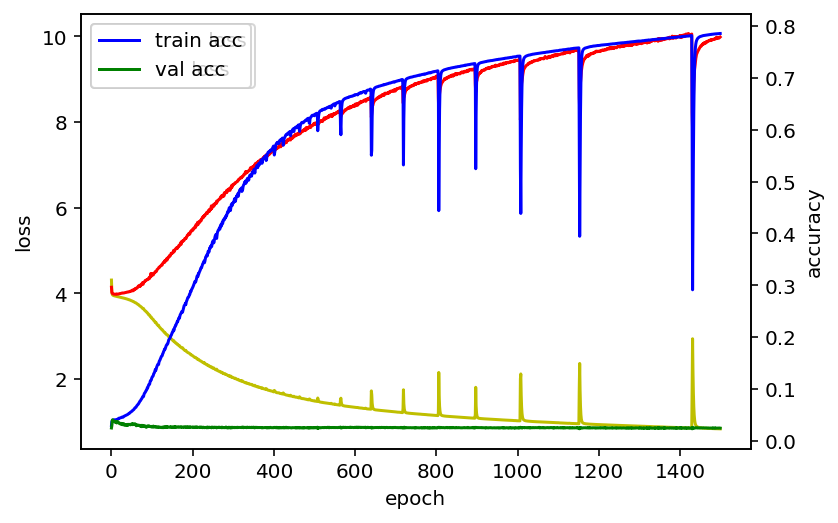

In [ ]:
#Visualization
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_note.history['loss'], 'y', label='train loss')
loss_ax.plot(hist_note.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist_note.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist_note.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
#Time1 model compile and train
time1_model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy", metrics=['accuracy'])
hist_time1 = time1_model.fit(np_input, np_label_time1, epochs=500, batch_size=8192, validation_split=0.4)

Epoch 1/500
1/7 [===>..........................] - ETA: 7s - loss: 4.7272 - accuracy: 0.0251WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_train_batch_end` time: 0.0203s). Check your callbacks.


7/7 [==============================] - ETA: 0s - loss: 4.6642 - accuracy: 0.1322WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0016s vs `on_test_batch_end` time: 0.0143s). Check your callbacks.


7/7 [==============================] - 5s 648ms/step - loss: 4.6642 - accuracy: 0.1322 - val_loss: 4.5456 - val_accuracy: 0.2250
Epoch 2/500
7/7 [==============================] - 1s 78ms/step - loss: 4.2693 - accuracy: 0.2444 - val_loss: 3.7122 - val_accuracy: 0.2123
Epoch 3/500
7/7 [==============================] - 1s 76ms/step - loss: 3.2854 - accuracy: 0.2312 - val_loss: 3.2451 - val_accuracy: 0.1470
Epoch 4/500
7/7 [==============================] - 1s 80ms/step - loss: 2.8496 - accuracy: 0.1997 - val_loss: 2.6357 - val_accuracy: 0.2358
Epoch 5/500
7/7 [==============================] - 1s 79ms/step - loss: 2.4402 - accuracy: 0.2518 - val_loss: 2.5138 - val_accuracy: 0.2247
Epoch 6/500
7/7 [==============================] - 1s 78ms/step - loss: 2.4004 - accuracy: 0.2553 - val_loss: 2.4861 - val_accuracy: 0.2508
Epoch 7/500
7/7 [==============================] - 1s 79ms/step - loss: 2.3588 - accuracy: 0.2559 - val_loss: 2.4672 - val_accuracy: 0.2480
Epoch 8/500
7/7 [==============

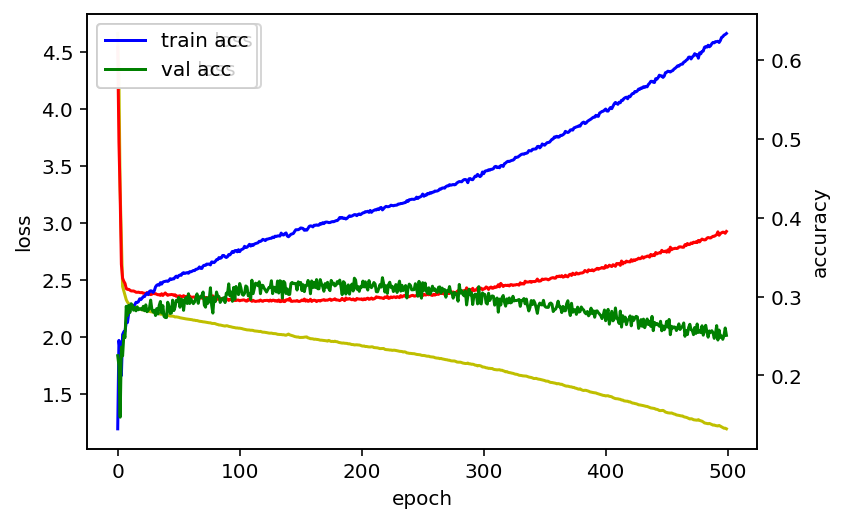

In [ ]:
#Visualization
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_time1.history['loss'], 'y', label='train loss')
loss_ax.plot(hist_time1.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist_time1.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist_time1.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
#Time2 model compile and train
time2_model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy", metrics=['accuracy'])
hist_time2 = time2_model.fit(np_input, np_label_time2, epochs=500, batch_size=8192, validation_split=0.4)

Epoch 1/500
1/7 [===>..........................] - ETA: 7s - loss: 4.8974 - accuracy: 0.0270WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_train_batch_end` time: 0.0191s). Check your callbacks.


7/7 [==============================] - ETA: 0s - loss: 4.8143 - accuracy: 0.1933WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_test_batch_end` time: 0.0115s). Check your callbacks.


7/7 [==============================] - 5s 644ms/step - loss: 4.8143 - accuracy: 0.1933 - val_loss: 4.6571 - val_accuracy: 0.2464
Epoch 2/500
7/7 [==============================] - 1s 77ms/step - loss: 4.2835 - accuracy: 0.2670 - val_loss: 3.6341 - val_accuracy: 0.2497
Epoch 3/500
7/7 [==============================] - 1s 79ms/step - loss: 3.3065 - accuracy: 0.2552 - val_loss: 3.1894 - val_accuracy: 0.1807
Epoch 4/500
7/7 [==============================] - 1s 78ms/step - loss: 2.9060 - accuracy: 0.2023 - val_loss: 2.6389 - val_accuracy: 0.2938
Epoch 5/500
7/7 [==============================] - 1s 78ms/step - loss: 2.4444 - accuracy: 0.2854 - val_loss: 2.2341 - val_accuracy: 0.2807
Epoch 6/500
7/7 [==============================] - 1s 78ms/step - loss: 2.2315 - accuracy: 0.2898 - val_loss: 2.1704 - val_accuracy: 0.2810
Epoch 7/500
7/7 [==============================] - 1s 82ms/step - loss: 2.2015 - accuracy: 0.2918 - val_loss: 2.1476 - val_accuracy: 0.3084
Epoch 8/500
7/7 [==============

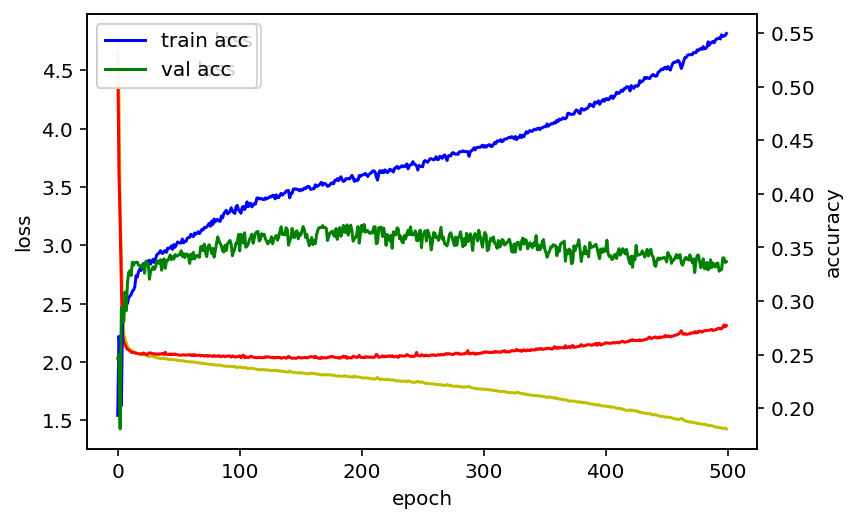

In [ ]:
#Visualization
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_time2.history['loss'], 'y', label='train loss')
loss_ax.plot(hist_time2.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist_time2.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist_time2.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
#save model 

note_model.save('/content/drive/My Drive/Colab Notebooks/trained_note.h5')
time1_model.save('/content/drive/My Drive/Colab Notebooks/trained_time1.h5')
time2_model.save('/content/drive/My Drive/Colab Notebooks/trained_time2.h5')

# **Prediction and Generating Output**
*by Seungil Baek*

In [ ]:
#doremi is our testing input
doremi1 = np.array([[0.3922267605836423, -1.0, 0.12500000000000006] ,[0.29682025125248607, 0.28571428571428564, 0.12500000000000006] ,[0.20141374192132983, 0.28571428571428564, 0.12500000000000006] ,[0.29682025125248607, 0.28571428571428564, 0.12500000000000006] ,[0.3922267605836423, 0.28571428571428564, 0.12500000000000006] ,[0.3922267605836423, 0.28571428571428564, 0.12500000000000006] ,[0.3922267605836423, 0.28571428571428564, 0.12500000000000006] ,[0.29682025125248607, 0.28571428571428564, 0.12500000000000006] ])
doremi2 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])

doremi1 = doremi1[newaxis,:,:]
doremi2 = doremi2[newaxis,:,:]

In [ ]:
#Only works for many to one model
#Fucntion which converts one hot code to readable output
#prediction input should be shape of (1,8,3)

def predict_future(prediction_input):
  predicted_note = note_info[np.argmax(note_model.predict(prediction_input), axis=-1)[0]]
  predicted_time1 = time1_info[np.argmax(time1_model.predict(prediction_input), axis=-1)[0]]
  predicted_time2 = max(1,time2_info[np.argmax(time2_model.predict(prediction_input), axis=-1)[0]])

  next_info = [predicted_note, predicted_time1, predicted_time2]

  return next_info

def predicts_a_song(prediction_input, predic_num):
  input = prediction_input.tolist()
  output = []

  for eachinfo in input[0]:
      output.append([int(note_mean + note_std*eachinfo[0]), int(time1_mean + time1_std*eachinfo[1])/12, int(time2_mean + time2_std*eachinfo[2])/12])

  for i in range (0, predic_num):
    starttime = time.time()
    nextstepinfo = predict_future(input)

    output.append([nextstepinfo[0],nextstepinfo[1]/12,nextstepinfo[2]/12])

    input_next_note = (nextstepinfo[0] - note_mean) / note_std
    input_next_time1 = (nextstepinfo[1] - time1_mean) / time1_std
    input_next_time2 = (nextstepinfo[2] - time2_mean) / time2_std

    input[0].append([input_next_note, input_next_time1, input_next_time2])
    good_bye = input[0].pop(0)

    print('Number of note added in your melody is now:', i+1, ", The time consumed in this step is:", time.time() - starttime, 's')
  
  print('done!')
  return output

In [ ]:
#Prediction and Generation

predic_num = 300
my_song = predicts_a_song(doremi1, predic_num)
print(my_song)
print('There is your song!')

Number of note added in your melody is now: 1 , The time consumed in this step is: 2.1294150352478027 s
Number of note added in your melody is now: 2 , The time consumed in this step is: 2.1216511726379395 s
Number of note added in your melody is now: 3 , The time consumed in this step is: 2.1440396308898926 s
Number of note added in your melody is now: 4 , The time consumed in this step is: 2.18086314201355 s
Number of note added in your melody is now: 5 , The time consumed in this step is: 2.15702748298645 s
Number of note added in your melody is now: 6 , The time consumed in this step is: 2.1405715942382812 s
Number of note added in your melody is now: 7 , The time consumed in this step is: 2.105665922164917 s
Number of note added in your melody is now: 8 , The time consumed in this step is: 2.1415138244628906 s
Number of note added in your melody is now: 9 , The time consumed in this step is: 4.539949893951416 s
Number of note added in your melody is now: 10 , The time consumed in 

# **Output Sequence Postprocess**
*by Sunghoon Kim*

In [ ]:
import music21

In [ ]:
from keras.models import load_model

#note_model = load_model("/content/drive/My Drive/Colab Notebooksoverfitted_note.h5")
#time1_model = load_model("/content/drive/My Drive/Colab Notebooksoverfitted_time1.h5")
#time2_model = load_model("/content/drive/My Drive/Colab Notebooksoverfitted_time2.h5")

In [ ]:
def list_to_stream(curve_seq):
    stream = music21.stream.Stream()
    
    for vector in curve_seq:
        n = music21.note.Note(vector[0],quarterLength=vector[2])
        n.offset = vector[1]
        stream.append(n)
    return stream
    
s_test = list_to_stream(my_song)
test_mid = music21.midi.translate.streamToMidiFile(s_test)

test_mid.open('/content/drive/My Drive/Colab Notebooks/whynot.mid', 'wb')
test_mid.write()
test_mid.close()
print('your song is saved!')

your song is saved!


# **Model Visualization**

In [ ]:
!pip install graphviz
!pip install pydot

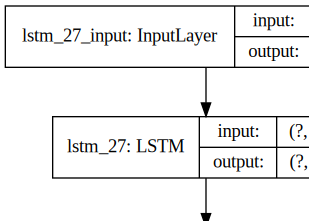

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(note_model, show_shapes=True).create(prog='dot', format='svg'))

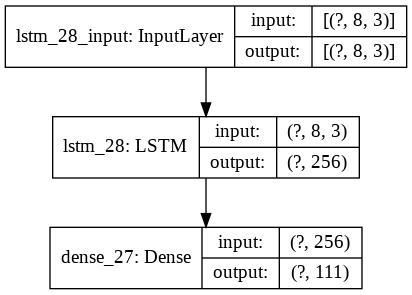

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

plot_model(time2_model, to_file='model.png')
plot_model(time1_model, to_file='model_shapes.png', show_shapes=True)